In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

## **0. Chuẩn bị**

### **Một vài function...**

In [38]:
def get_date(datetime: str):
    return datetime.split()[0]

def get_time(datetime: str):
    return datetime.split()[1]

### **Vẽ biểu đồ**

In [39]:
def plot_result(data_dbd: pd.DataFrame, index: int, pred_list: list[float]):
    df = data_dbd.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'][index:], df['Change'][index:], label='Thực tế', color='blue')

    plt.plot(df['Date'][index:], pred_list, label='Dự đoán', color='red', linestyle='dashed')

    plt.title('So sánh biến động giá trên thực tế và dự đoán')
    plt.xlabel('Ngày')
    plt.ylabel('Biến động giá (nghìn VNĐ)')
    plt.legend()
    plt.show()

### **Chuyển đổi dữ liệu**

Dữ liệu giao dịch theo *từng phút* chuyển sang *từng ngày*

In [40]:
def day_by_day(df: pd.DataFrame) -> pd.DataFrame:
    COLS_NAME = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

    interval = df['Date'].drop_duplicates().to_list()

    new_df = []

    for date in interval:        
        rows = df[(df['Date'] == date)]
        
        max_high = rows['High'].max()
        min_low = rows['Low'].min()

        first_open = rows.iat[0,1]
        last_close = rows.iat[len(rows)-1,4]

        sum_volume = rows['Volume'].sum()

        new_df.append([date, first_open, max_high, min_low, last_close, sum_volume])

    return pd.DataFrame(new_df, columns=COLS_NAME)
    

### **Biến động giá cổ phiếu**
*Giá trị này được tính theo ngày*

In [41]:
def add_new_col(df: pd.DataFrame):
    change = [0]

    for i in range(0,len(df)-1):
        change.append(df.iat[i+1,4]-df.iat[i,4])

    df['Change'] = change

### **Ước lượng giá trị High và Low**
*Sử dụng Moving Average của 03 ngày gần nhất*

*Áp dụng cho bộ dữ liệu X_test*

In [42]:
def ma_estimate(df: pd.DataFrame, index: int):
    df_copy = df.copy()
    
    for i in range(index, len(df)):
        df_copy.iat[i,1] = round((df.iat[i-3,1] + df.iat[i-2,1] + df.iat[i-1,1])/3, 2)
        df_copy.iat[i,2] = round((df.iat[i-3,2] + df.iat[i-2,2] + df.iat[i-1,2])/3, 2)

    df[['High', 'Low']] = df_copy[['High', 'Low']]

### **Load dữ liệu**
*Sử dụng file PNJ.csv (có thể sử dụng các file dữ liệu khác thay thế)*

In [43]:
data = pd.read_csv('PNJ.csv')

## **1. Xử lý dữ liệu**

### **Tách Date/Time trở thành Date và Time,**
### **Loại bỏ những cột không cần thiết: Ticker, Date/Time và Open Interest**

In [44]:
data['Date'] = data['Date/Time'].apply(get_date)
data['Time'] = data['Date/Time'].apply(get_time)

data = data.drop(['Open Interest', 'Date/Time'], axis=1)

### **Lấy dữ liệu theo ngày**

In [45]:
data_dbd = day_by_day(data)

print(data_dbd)

           Date   Open   High    Low  Close   Volume
0     2/28/2018  78.14  80.61  78.09  78.71     8158
1      3/1/2018  78.14  80.32  77.66  77.66    20511
2      3/2/2018  77.14  77.90  76.86  77.33    37274
3      3/5/2018  77.14  80.50  77.14  78.28    27737
4      3/6/2018  78.61  83.13  77.43  81.45    41077
..          ...    ...    ...    ...    ...      ...
704  12/16/2020  77.20  77.60  77.00  77.60   636190
705  12/17/2020  76.50  77.40  75.00  75.80  1289500
706  12/18/2020  75.80  77.50  75.80  77.30   582740
707  12/21/2020  77.30  77.40  76.50  77.30   676290
708  12/22/2020  77.70  78.70  77.00  78.30   957080

[709 rows x 6 columns]


### **Thêm cột biến động giá**

Mức độ chênh lệch của giá đóng cửa ngày hôm nay so với hôm qua

In [46]:
add_new_col(data_dbd)

print(data_dbd)

           Date   Open   High    Low  Close   Volume  Change
0     2/28/2018  78.14  80.61  78.09  78.71     8158    0.00
1      3/1/2018  78.14  80.32  77.66  77.66    20511   -1.05
2      3/2/2018  77.14  77.90  76.86  77.33    37274   -0.33
3      3/5/2018  77.14  80.50  77.14  78.28    27737    0.95
4      3/6/2018  78.61  83.13  77.43  81.45    41077    3.17
..          ...    ...    ...    ...    ...      ...     ...
704  12/16/2020  77.20  77.60  77.00  77.60   636190    0.50
705  12/17/2020  76.50  77.40  75.00  75.80  1289500   -1.80
706  12/18/2020  75.80  77.50  75.80  77.30   582740    1.50
707  12/21/2020  77.30  77.40  76.50  77.30   676290    0.00
708  12/22/2020  77.70  78.70  77.00  78.30   957080    1.00

[709 rows x 7 columns]


***NOTE**: Dòng đầu tiên của dataset sẽ không có dữ liệu do thiếu dữ liệu của ngày hôm trước.*

### **Mô tả dataset**

In [47]:
data_dbd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    709 non-null    object 
 1   Open    709 non-null    float64
 2   High    709 non-null    float64
 3   Low     709 non-null    float64
 4   Close   709 non-null    float64
 5   Volume  709 non-null    int64  
 6   Change  709 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 38.9+ KB


### **Nhận xét trên bộ dữ liệu của PNJ**
*Dữ liệu được 'nén' từ xấp xỉ 100,000 xuống còn 709 dòng,*

*Không tồn tại giá trị null,*

*Từ kết quả trên, có thể nhận thấy dữ liệu được ghi nhận từ 28/02/2018 đến 22/12/2020.*

## **2. Phân chia dataset**

### **Kiểm tra hệ số tương quan**

In [48]:
attribute_data = data_dbd.drop(['Date', 'Change'], axis=1)

attribute_data.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.992990,0.993992,0.986643,-0.212151
High,0.992990,1.000000,0.992219,0.992959,-0.205463
Low,0.993992,0.992219,1.000000,0.993224,-0.225731
Close,0.986643,0.992959,0.993224,1.000000,-0.203914
Volume,-0.212151,-0.205463,-0.225731,-0.203914,1.000000


### **Tiến hành**

In [49]:
index = int(len(data_dbd)*0.8)

scaler = StandardScaler()

ma_estimate(data_dbd, index=index)

dbd_scale = scaler.fit_transform(data_dbd[['Open', 'High', 'Low', 'Change']])
data_dbd[['Open', 'High', 'Low', 'Change']] = dbd_scale

X, y = data_dbd.drop(['Date', 'Close', 'Volume', 'Change'], axis=1), data_dbd['Change']

X_train, X_test = X[:index], X[index:]
y_train, y_test = y[:index], y[index:]

### **NOTE:**

Độ tương quan của *Volume* qua tính toán là xấp xỉ -0.2, thấp hơn khá nhiều so với các giá trị còn lại (đều lớn hơn 0.90), vì thế đã được loại bỏ.

Qua việc phân chia ở trên có thể thấy đầu vào (input) của các mô hình dự đoán sắp tới sẽ bao gồm các thuộc tính *Open, High và Low* nhằm đưa ra kết quả của *Change*.

Mục tiêu hướng đến của mô hình là đưa ra biến động của giá mở NGÀY MAI so với NGÀY HÔM NAY. Như vậy, những dữ liệu nằm trong X_test (đại diện cho tương lai) ngoại trừ *Open* (giá tham chiếu được xác định dựa trên giá đóng của của phiên giao dịch gần nhất) như *High và Low* là **CHƯA tồn tại**.

Do đó, hướng xử lý đơn giản trong trường hợp này là sử dụng **Moving Average** để ước lượng hai giá trị *High và Low* của ngày kế tiếp (sử dụng hàm ma_estimate).

## **3. Áp dụng Linear Regression**

### **Triển khai**

In [50]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_pred_lr, y_test))

print(rmse)

0.8352754152775435


### **So sánh trên biểu đồ**

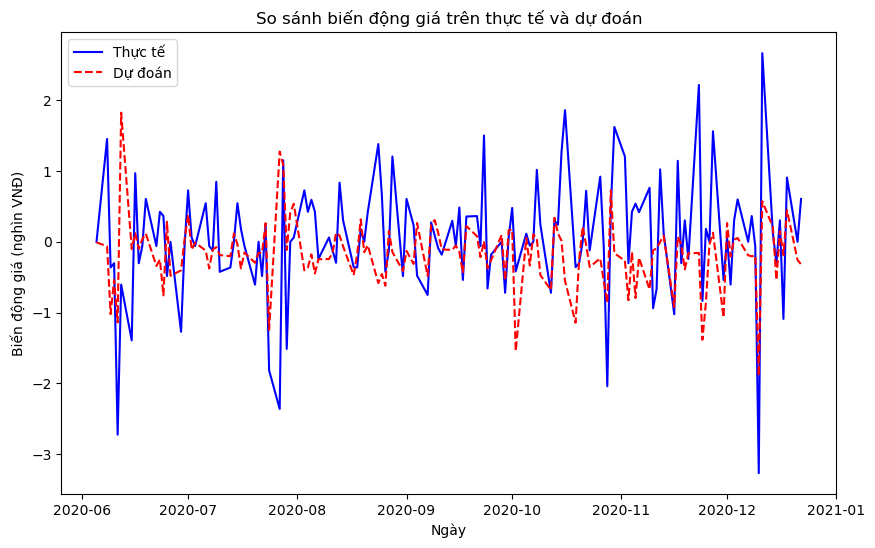

In [51]:
plot_result(data_dbd, index, y_pred_lr)

## **4. Áp dụng SVR**

### **Triển khai**

In [52]:
svr = SVR(kernel='linear', C=500, epsilon=0.6)
svr.fit(X_train, y_train)

y_pred_svr = svr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_pred_svr, y_test))

print(rmse)

0.8078087962894044


### **So sánh trên biểu đồ**

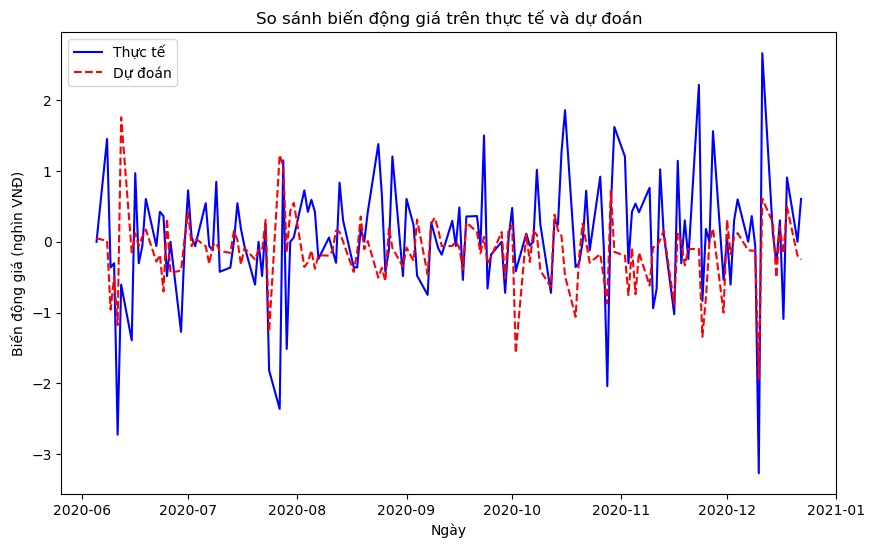

In [53]:
plot_result(data_dbd, index, y_pred_svr)

## **5. Áp dụng Random Forest**

### **Triển khai**

In [54]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_pred_rf, y_test))

print(rmse)

0.823257470845231


### **So sánh trên biểu đồ**

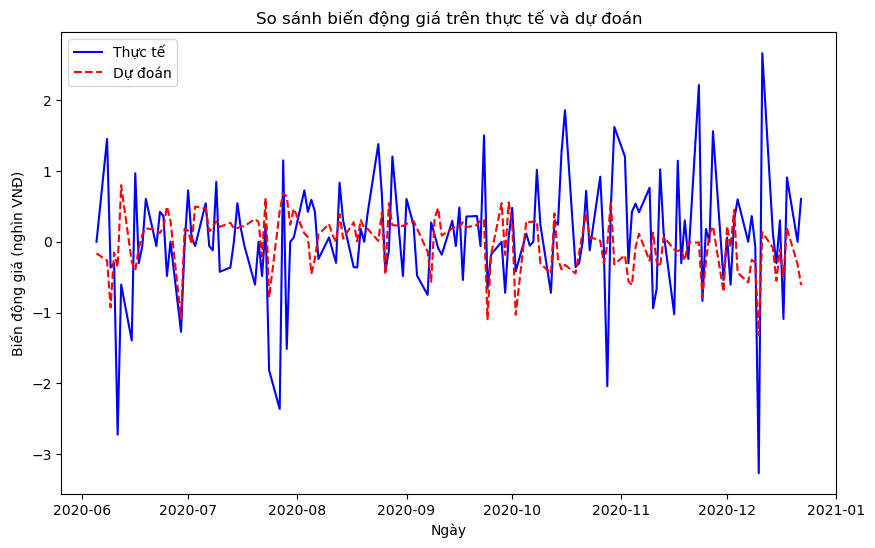

In [55]:
plot_result(data_dbd, index, y_pred_rf)

## **6. Đánh giá**

Đã xây dựng được model dự đoán biến động giá cổ phiếu đơn giản.

Các model vào nhiều thời điểm dự đoán đúng xu hướng tăng/giảm của thị trường, tuy nhiên chưa đưa ra được kết quả chính xác cao hơn.